# 🏀 Cavaliers Data Explorer

**Timing Guide:**
- Setup: 30 seconds
- Task 1 (Find Cavs): 1 minute
- Task 2 (Compare teams): 2 minutes
- Task 3 (Cavs record): 1-2 minutes
- Viz 1 (Team comparison): 1 minute
- Get player data: 30 seconds
- Viz 2 (Player stats): 1-2 minutes
- Viz 3 (Bubble chart): 2 minutes
- Wrap up: 1 minute

**Total: 7-10 minutes** 

---

## Setup

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Connect to database
conn = sqlite3.connect('nba_5seasons.db')

print("✅ Connected to NBA database!")
print("✅ Visualization tools loaded!")
print("\n🏀 Ready to explore the Cavs!")

✅ Connected to NBA database!
✅ Visualization tools loaded!

🏀 Ready to explore the Cavs!


---

## Task 1: Fix the Query - Find the Cavs! 🔧

**ANSWER:** Change `'Los Angeles'` to `'Cleveland'`

**Teaching Tips:**
- Point to line 11 (WHERE clause)
- Ask: "What city are the Cavs in?"
- If stuck: "Look at the WHERE line - what city should we search for?"
- Build excitement: "Let's find our home team!"

In [2]:
# SOLUTION:
query = """
SELECT 
    full_name,
    city,
    state,
    nickname,
    year_founded
FROM teams
WHERE city = 'Cleveland'
ORDER BY full_name;
"""

cavs_info = pd.read_sql(query, conn)
display(cavs_info)

print(f"\n✅ Found the Cavs!")

,full_name,city,state,nickname,year_founded
0,Cleveland Cavaliers,Cleveland,Ohio,Cavaliers,1970



✅ Found the Cavs!


---

## Task 2: How Do the Cavs Compare? 📊

**ANSWERS:**
1. First blank: `AVG`
2. Second blank: `t.full_name` (or `t.team_id, t.full_name`)

**Teaching Tips:**
- Hint: "We're calculating AVERAGE points - what SQL function does that?"
- Hint: "The GROUP BY needs to match what we're selecting - what's the team column?"
- Point out the season: "This is THIS YEAR's data - 2024-25!"
- After running: "Let's see where the Cavs rank!"

In [3]:
# SOLUTION:
query = """
SELECT 
    t.full_name AS team,
    t.city,
    COUNT(tgs.game_id) AS games_played,
    ROUND(AVG(tgs.pts), 1) AS avg_points_per_game
FROM teams t
JOIN team_game_stats tgs ON t.team_id = tgs.team_id
WHERE tgs.season = '2024-25'
GROUP BY t.full_name
ORDER BY avg_points_per_game DESC
LIMIT 10;
"""

top_scorers = pd.read_sql(query, conn)
display(top_scorers)

# Check if Cavs made the top 10!
if 'Cleveland Cavaliers' in top_scorers['team'].values:
    cavs_rank = top_scorers[top_scorers['team'] == 'Cleveland Cavaliers'].index[0] + 1
    print(f"\n🏆 Cavs are ranked #{cavs_rank} in scoring!")
else:
    print("\n📊 Cavs just outside the top 10 in scoring")

print(f"✅ Found the top {len(top_scorers)} scoring teams!")

,team,city,games_played,avg_points_per_game
0,Cleveland Cavaliers,Cleveland,82,121.9
1,Memphis Grizzlies,Memphis,82,121.7
2,Denver Nuggets,Denver,82,120.8
3,Oklahoma City Thunder,Oklahoma City,82,120.5
4,Atlanta Hawks,Atlanta,82,118.2
5,Chicago Bulls,Chicago,82,117.8
6,Indiana Pacers,Indiana,82,117.4
7,Boston Celtics,Boston,82,116.3
8,New York Knicks,New York,82,115.8
9,Sacramento Kings,Sacramento,82,115.7



🏆 Cavs are ranked #1 in scoring!
✅ Found the top 10 scoring teams!


---

## Task 3: Cavs Win Record 🏆

**ANSWER:** `WHERE t.full_name = 'Cleveland Cavaliers'`

**Teaching Tips:**
- Point to line 12 (commented WHERE line)
- Hint: "Remove the -- and type: WHERE t.full_name = 'Cleveland Cavaliers'"
- Explain: "The WHERE filters down to just one team before we calculate stats"
- Show the CASE statement: "This counts W's as 1, L's as 0, then sums them up!"
- After running: "Check out that win percentage! 🏆"

In [4]:
# SOLUTION:
query = """
SELECT 
    t.full_name AS team,
    SUM(CASE WHEN tgs.wl = 'W' THEN 1 ELSE 0 END) AS wins,
    SUM(CASE WHEN tgs.wl = 'L' THEN 1 ELSE 0 END) AS losses,
    ROUND(SUM(CASE WHEN tgs.wl = 'W' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) AS win_percentage
FROM teams t
JOIN team_game_stats tgs ON t.team_id = tgs.team_id
WHERE t.full_name = 'Cleveland Cavaliers'
   AND tgs.season = '2024-25'
GROUP BY t.full_name;
"""

cavs_record = pd.read_sql(query, conn)
display(cavs_record)

if len(cavs_record) > 0:
    print(f"\n✅ Cavs Record: {cavs_record.iloc[0]['wins']}-{cavs_record.iloc[0]['losses']}")
    print(f"🎯 Win Percentage: {cavs_record.iloc[0]['win_percentage']}%")

,team,wins,losses,win_percentage
0,Cleveland Cavaliers,64,18,78.0



✅ Cavs Record: 64-18
🎯 Win Percentage: 78.0%


---

## 🎨 Visualization 1: Cavs vs Top Scorers

**Teaching Tips:**
- Build it up: "Now watch this - we're going to turn that data into a chart!"
- Point out: "See the wine and gold? That's the Cavs!"
- Explain: "The data we queried is now a professional visualization"
- Ask: "Where do the Cavs rank?"

C:\Users\mc_lsprecher27\AppData\Local\Temp\ipykernel_17440\779609007.py:131: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=2)
C:\Users\mc_lsprecher27\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


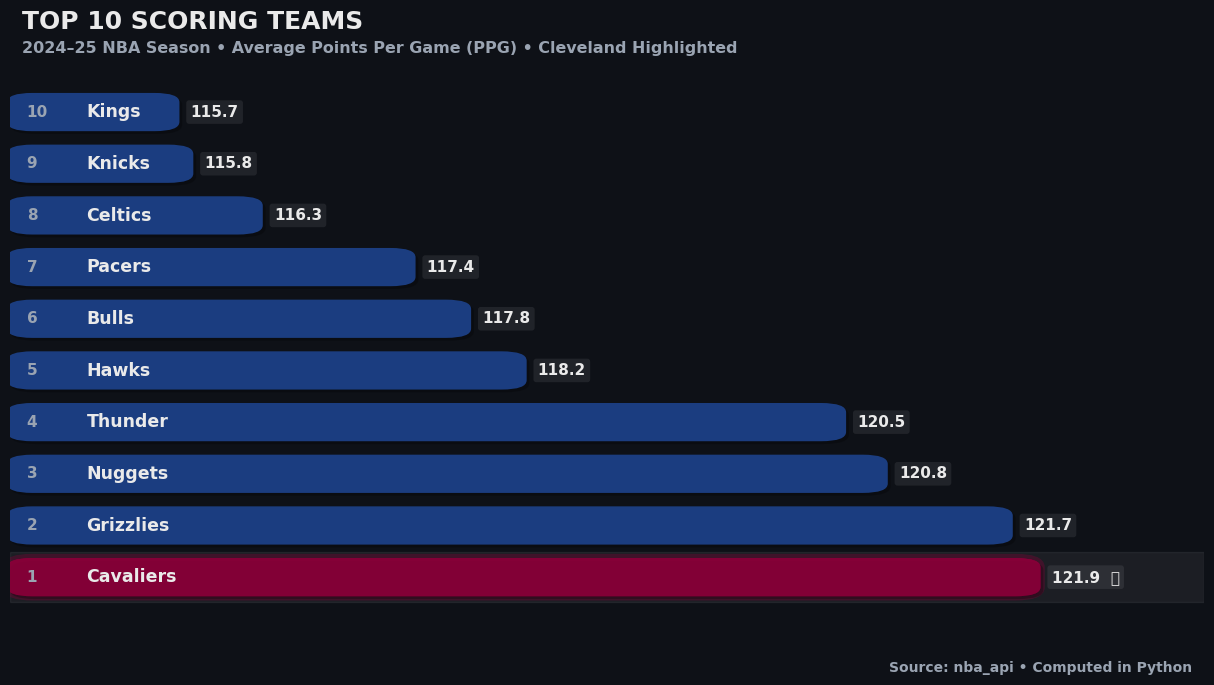

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import FancyBboxPatch
import numpy as np

# ------------------ STYLE ------------------
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.weight'] = 'bold'

CAVS_WINE = '#860038'
NBA_BLUE = '#1D428A'
BACKGROUND = '#0E1117'
TEXT = '#EAEAEA'
MUTED = '#9AA4B2'   # soft gray-blue for secondary text

# ------------------ HELPERS ------------------
def display_team(full_name: str) -> str:
    """
    Convert 'Cleveland Cavaliers' -> 'Cavaliers'
    Handles a couple NBA edge cases where the nickname is 2 words.
    """
    two_word = {"Trail Blazers"}  # expand if you want
    parts = full_name.split()
    if len(parts) >= 2 and " ".join(parts[-2:]) in two_word:
        return " ".join(parts[-2:])
    return parts[-1]  # last word = nickname for most teams

# ------------------ DATA ------------------
teams = list(top_scorers['team'])
ppg = np.array(top_scorers['avg_points_per_game'], dtype=float)

team_labels = [display_team(t) for t in teams]

colors = [CAVS_WINE if t == 'Cleveland Cavaliers' else NBA_BLUE for t in teams]

# ------------------ FIGURE ------------------
fig, ax = plt.subplots(figsize=(12.5, 7.2), facecolor=BACKGROUND)
ax.set_facecolor(BACKGROUND)

# Tight axis (little padding)
xmin = ppg.min() - 1.2
xmax = ppg.max() + 1.2
ax.set_xlim(xmin, xmax)

# Y positions
y = np.arange(len(teams))
bar_h = 0.70

# Optional: highlight band behind Cavs row
if 'Cleveland Cavaliers' in teams:
    i_cavs = teams.index('Cleveland Cavaliers')
    ax.axhspan(i_cavs - 0.48, i_cavs + 0.48, color='white', alpha=0.06, zorder=0)

# Draw rounded bars manually
for i, (team, team_label, val, col) in enumerate(zip(teams, team_labels, ppg, colors)):
    # Rounded rectangle bar
    rect = FancyBboxPatch(
        (xmin, i - bar_h/2),          # (x, y) bottom-left
        val - xmin,                   # width
        bar_h,                        # height
        boxstyle="round,pad=0.02,rounding_size=0.18",
        linewidth=0,
        facecolor=col,
        alpha=0.92,
        zorder=2
    )

    # Shadow (subtle) + extra glow for Cavs
    effects = [
        pe.SimplePatchShadow(offset=(2, -2), alpha=0.25, shadow_rgbFace=(0, 0, 0)),
        pe.Normal()
    ]
    if team == 'Cleveland Cavaliers':
        effects.insert(0, pe.withStroke(linewidth=6, foreground=CAVS_WINE, alpha=0.35))  # glow edge

    rect.set_path_effects(effects)
    ax.add_patch(rect)

    # Rank number (left)
    ax.text(
        xmin + 0.12, i, f"{i+1}",
        va='center', ha='left',
        fontsize=11, color=MUTED, zorder=3
    )

    # Team label (nickname only)
    ax.text(
        xmin + 0.55, i, team_label,
        va='center', ha='left',
        fontsize=12.5, color=TEXT, zorder=3
    )

    # Value "pill" at end of bar
    pill_text = f"{val:.1f}" + ("  🏆" if team == 'Cleveland Cavaliers' else "")
    ax.text(
        val + 0.10, i, pill_text,
        va='center', ha='left',
        fontsize=11, color=TEXT,
        bbox=dict(
            boxstyle="round,pad=0.28,rounding_size=0.18",
            facecolor="white", edgecolor="none", alpha=0.08
        ),
        zorder=4
    )

# ------------------ CLEANUP ------------------
ax.set_yticks([])                 # we drew our own team labels
ax.set_xticks([])                 # super clean look (no axis ticks)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)

# Title + subtitle (modern hierarchy)
ax.text(
    0.01, 1.06, "TOP 10 SCORING TEAMS",
    transform=ax.transAxes,
    fontsize=18, color=TEXT, ha='left', va='bottom'
)
ax.text(
    0.01, 1.02, "2024–25 NBA Season • Average Points Per Game (PPG) • Cleveland Highlighted",
    transform=ax.transAxes,
    fontsize=11.5, color=MUTED, ha='left', va='bottom'
)

# Small footer / source note vibe
ax.text(
    0.99, -0.06, "Source: nba_api • Computed in Python",
    transform=ax.transAxes,
    fontsize=10, color=MUTED, ha='right', va='top'
)

plt.tight_layout(pad=2)
plt.show()


---

## Get Cavs Player Data

**Teaching Tips:**
- Transition: "Now let's look at individual Cavs players!"
- Point out: "This joins THREE tables together - teams, players, and stats"
- Ask: "Do you recognize any of these names?"
- Build anticipation: "Wait until you see the visualizations!"

In [6]:
# Get Cavs player stats
query = """
SELECT 
    p.full_name AS player,
    pss.gp AS games_played,

    ROUND(pss.pts * 1.0 / pss.gp, 1) AS points_per_game,
    ROUND(pss.reb * 1.0 / pss.gp, 1) AS rebounds_per_game,
    ROUND(pss.ast * 1.0 / pss.gp, 1) AS assists_per_game,

    ROUND(pss.fg_pct * 100, 1) AS field_goal_pct
FROM players p
JOIN player_season_stats pss 
    ON p.player_id = pss.player_id
JOIN teams t 
    ON pss.team_id = t.team_id
WHERE t.full_name = 'Cleveland Cavaliers'
  AND pss.season = '2024-25'
  AND pss.gp >= 10
ORDER BY points_per_game DESC
LIMIT 10;
"""

cavs_players = pd.read_sql(query, conn)
display(cavs_players)

print(f"\n✅ Top {len(cavs_players)} Cavs scorers this season!")

,player,games_played,points_per_game,rebounds_per_game,assists_per_game,field_goal_pct
0,Donovan Mitchell,71,24.0,4.5,5.0,44.3
1,Darius Garland,75,20.6,2.9,6.7,47.2
2,Evan Mobley,71,18.5,9.3,3.2,55.7
3,De'Andre Hunter,64,17.0,4.0,1.4,47.0
4,Jarrett Allen,82,13.5,9.7,1.9,70.6
5,Ty Jerome,70,12.5,2.5,3.4,51.6
6,Max Strus,50,9.4,4.3,3.2,44.2
7,Sam Merrill,71,7.2,2.2,1.5,40.6
8,Isaac Okoro,55,6.1,2.4,1.2,46.4
9,Dean Wade,59,5.4,4.2,1.3,41.3



✅ Top 10 Cavs scorers this season!


---

## 🎨 Visualization 2: Cavs Starting Lineup Stats

**Teaching Tips:**
- "Check out this grouped bar chart - three stats side by side!"
- Point out the colors: "Wine, gold, and navy - Cavs colors!"
- Ask: "Who's the leading scorer? Rebounder? Assist leader?"
- Explain: "Each player gets three bars - easy to compare at a glance"

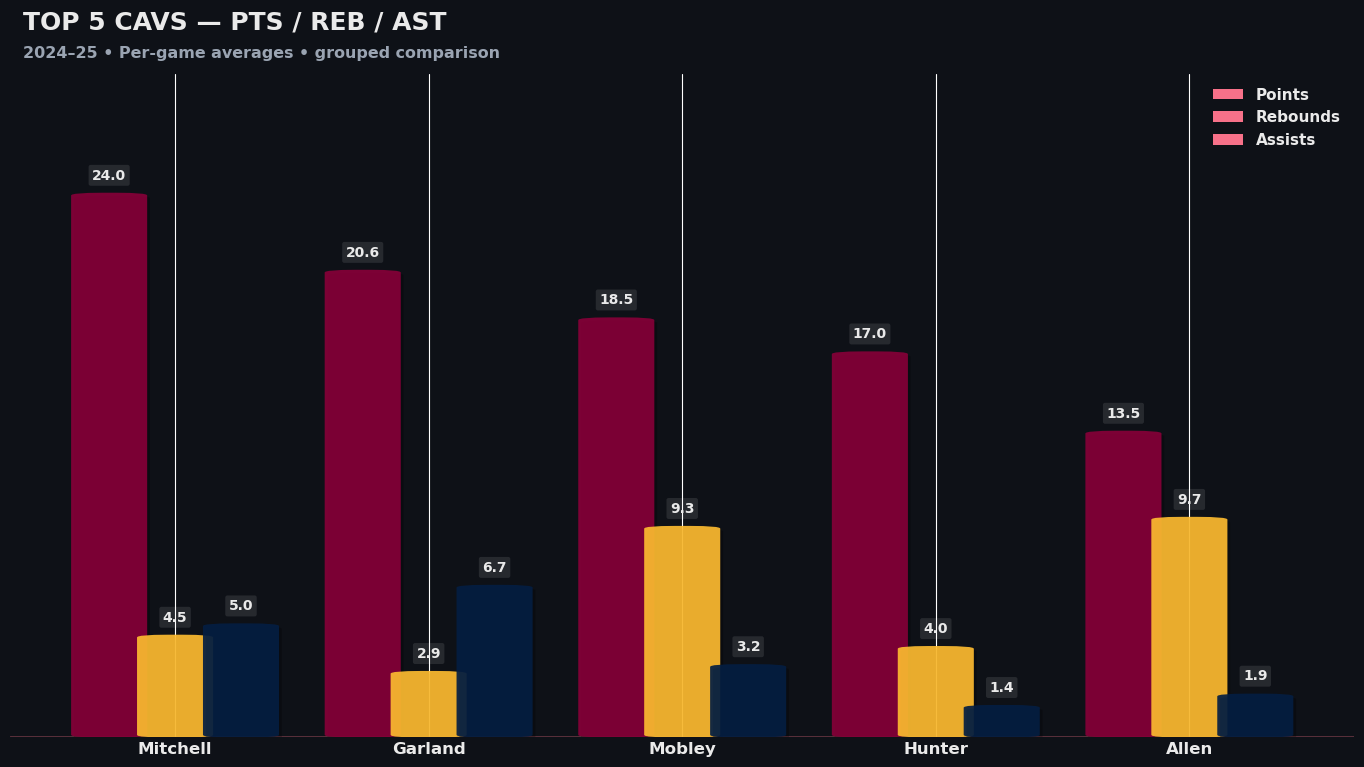


🍷 Cavs player comparison complete!


In [7]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import FancyBboxPatch
import numpy as np

# ------------------ DATA ------------------
top5_cavs = cavs_players.head(5).copy()

players = [p.split()[-1] for p in top5_cavs["player"]]
pts = top5_cavs["points_per_game"].astype(float).to_numpy()
reb = top5_cavs["rebounds_per_game"].astype(float).to_numpy()
ast = top5_cavs["assists_per_game"].astype(float).to_numpy()

# ------------------ STYLE ------------------
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.weight"] = "bold"

CAVS_WINE = "#860038"
GOLD = "#FDBB30"
NBA_BLUE = "#041E42"
BACKGROUND = "#0E1117"
TEXT = "#EAEAEA"
MUTED = "#9AA4B2"

# ------------------ FIGURE ------------------
fig, ax = plt.subplots(figsize=(14, 8), facecolor=BACKGROUND)
ax.set_facecolor(BACKGROUND)

# Positions
x = np.arange(len(players))
width = 0.26

# Helper to draw rounded bars + subtle shadow
def rounded_bars(x_centers, heights, offset, color, label):
    bars = []
    for xc, h in zip(x_centers, heights):
        x0 = (xc + offset) - width/2
        rect = FancyBboxPatch(
            (x0, 0),
            width,
            h,
            boxstyle="round,pad=0.02,rounding_size=0.12",
            linewidth=0,
            facecolor=color,
            alpha=0.92,
            zorder=3
        )
        rect.set_path_effects([
            pe.SimplePatchShadow(offset=(2, -2), alpha=0.25, shadow_rgbFace=(0, 0, 0)),
            pe.Normal()
        ])
        ax.add_patch(rect)
        bars.append(rect)

    # dummy artist so legend shows the right color/label
    ax.bar([], [], color=color, label=label, alpha=0.92)
    return bars

bars_pts = rounded_bars(x, pts, -width, CAVS_WINE, "Points")
bars_reb = rounded_bars(x, reb, 0.0, GOLD, "Rebounds")
bars_ast = rounded_bars(x, ast, +width, NBA_BLUE, "Assists")

# ------------------ AXES / LABELS ------------------
# Give headroom so value labels never collide with title/top
ymax = max(pts.max(), reb.max(), ast.max())
ax.set_ylim(0, ymax * 1.22)

# X labels (last names)
ax.set_xticks(x)
ax.set_xticklabels(players, rotation=0, fontsize=12, color=TEXT)

# Remove clutter
ax.set_yticks([])
for s in ["top", "right", "left", "bottom"]:
    ax.spines[s].set_visible(False)

# Title + subtitle
ax.text(
    0.01, 1.06, "TOP 5 CAVS — PTS / REB / AST",
    transform=ax.transAxes,
    fontsize=18, color=TEXT, ha="left", va="bottom"
)
ax.text(
    0.01, 1.02, "2024–25 • Per-game averages • grouped comparison",
    transform=ax.transAxes,
    fontsize=11.5, color=MUTED, ha="left", va="bottom"
)

# Subtle baseline
ax.axhline(0, linewidth=2, alpha=0.35)

# Legend (clean)
leg = ax.legend(loc="upper right", frameon=False, fontsize=11)
for t in leg.get_texts():
    t.set_color(TEXT)

# ------------------ VALUE LABELS (PILLS) ------------------
def add_pills(x_centers, heights, offset):
    for xc, h in zip(x_centers, heights):
        ax.text(
            (xc + offset),
            h + ymax * 0.02,
            f"{h:.1f}",
            ha="center",
            va="bottom",
            fontsize=10,
            color=TEXT,
            bbox=dict(
                boxstyle="round,pad=0.25,rounding_size=0.15",
                facecolor="white",
                edgecolor="none",
                alpha=0.10
            ),
            zorder=6
        )

add_pills(x, pts, -width)
add_pills(x, reb, 0.0)
add_pills(x, ast, +width)

plt.tight_layout(pad=2)
plt.show()

print("\n🍷 Cavs player comparison complete!")


---

## 🎨 Visualization 3: Cavs Shooting Efficiency Bubble Chart! 💫

**Teaching Tips:**
- **THIS IS YOUR SHOWSTOPPER!**
- Build excitement: "Okay, this last one is really cool - watch!"
- After it renders: "Whoa! Look at all that data in one chart!"
- Explain each dimension:
  - "Left to right = more points"
  - "Bottom to top = better shooting percentage"
  - "Bigger bubble = more games played"
  - "Warmer color = more assists"
- Point out the red line: "That's the league average - anyone above it is shooting better than average!"
- Let them find their favorite player
- Ask: "Who's the most efficient scorer? Who plays the most?"

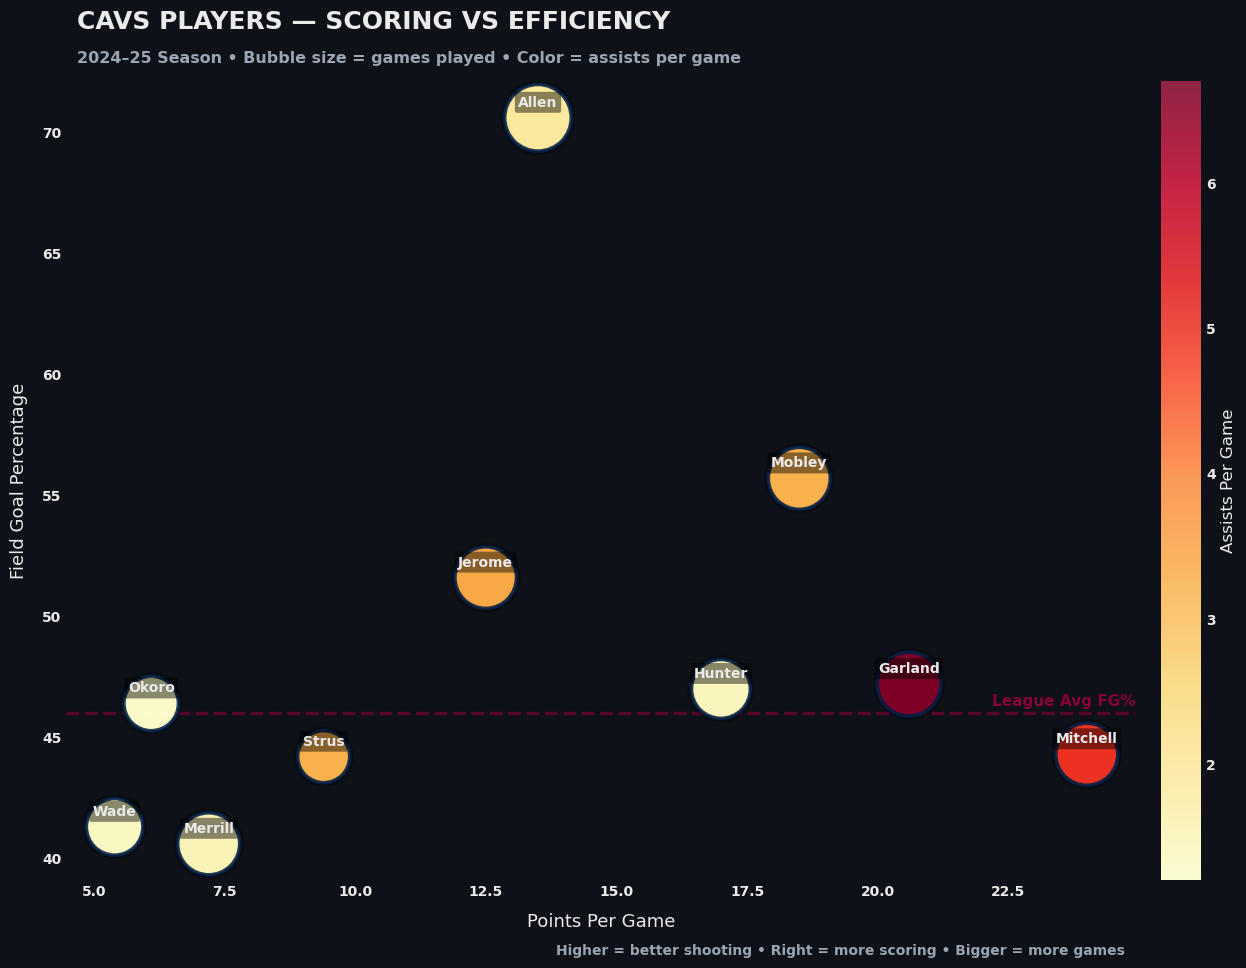


💫 Fancy Cavs bubble chart complete!


In [8]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np

# ------------------ STYLE ------------------
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.weight"] = "bold"

CAVS_WINE = "#860038"
NAVY = "#041E42"
BACKGROUND = "#0E1117"
TEXT = "#EAEAEA"
MUTED = "#9AA4B2"

# ------------------ FIGURE ------------------
fig, ax = plt.subplots(figsize=(14, 10), facecolor=BACKGROUND)
ax.set_facecolor(BACKGROUND)

# ------------------ SCATTER ------------------
scatter = ax.scatter(
    cavs_players["points_per_game"],
    cavs_players["field_goal_pct"],
    s=cavs_players["games_played"] * 28,      # Bubble size = games played
    c=cavs_players["assists_per_game"],       # Color = assists
    cmap="YlOrRd",
    alpha=0.85,
    edgecolors=NAVY,
    linewidths=2.5,
    zorder=3
)

# Add subtle glow to bubbles
scatter.set_path_effects([
    pe.withStroke(linewidth=6, foreground="black", alpha=0.25),
    pe.Normal()
])

# ------------------ PLAYER LABELS ------------------
for _, row in cavs_players.iterrows():
    last_name = row["player"].split()[-1]

    ax.text(
        row["points_per_game"],
        row["field_goal_pct"] + 0.35,   # lift label slightly above bubble
        last_name,
        fontsize=10,
        color=TEXT,
        ha="center",
        va="bottom",
        bbox=dict(
            boxstyle="round,pad=0.25,rounding_size=0.15",
            facecolor="black",
            edgecolor="none",
            alpha=0.45
        ),
        zorder=5
    )

# ------------------ REFERENCE LINE ------------------
league_avg_fg = 46

ax.axhline(
    league_avg_fg,
    color=CAVS_WINE,
    linestyle="--",
    linewidth=2.5,
    alpha=0.6,
    zorder=2
)

ax.text(
    ax.get_xlim()[1],
    league_avg_fg + 0.2,
    "League Avg FG%",
    color=CAVS_WINE,
    fontsize=11,
    ha="right",
    va="bottom"
)

# ------------------ AXES ------------------
ax.set_xlabel("Points Per Game", fontsize=13, color=TEXT, labelpad=10)
ax.set_ylabel("Field Goal Percentage", fontsize=13, color=TEXT, labelpad=10)

ax.tick_params(colors=TEXT)
for s in ["top", "right", "left", "bottom"]:
    ax.spines[s].set_visible(False)

ax.grid(False)

# ------------------ TITLE ------------------
ax.text(
    0.01, 1.06,
    "CAVS PLAYERS — SCORING VS EFFICIENCY",
    transform=ax.transAxes,
    fontsize=18,
    color=TEXT,
    ha="left",
    va="bottom"
)
ax.text(
    0.01, 1.02,
    "2024–25 Season • Bubble size = games played • Color = assists per game",
    transform=ax.transAxes,
    fontsize=11.5,
    color=MUTED,
    ha="left",
    va="bottom"
)

# ------------------ COLORBAR ------------------
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label("Assists Per Game", fontsize=12, color=TEXT)
cbar.ax.yaxis.set_tick_params(color=TEXT)
plt.setp(cbar.ax.get_yticklabels(), color=TEXT)
cbar.outline.set_visible(False)

# ------------------ FOOTNOTE ------------------
ax.text(
    0.99, -0.08,
    "Higher = better shooting • Right = more scoring • Bigger = more games",
    transform=ax.transAxes,
    fontsize=10,
    color=MUTED,
    ha="right",
    va="top"
)

plt.tight_layout(pad=2)
plt.show()

print("\n💫 Fancy Cavs bubble chart complete!")


---

## 🎯 Challenge Solutions

**Teaching Tips:**
- Only use if someone finishes early
- Guide them to write it themselves first
- Use as reference if stuck

In [9]:
# SOLUTION 1: Best Cavs rebounder
query = """
SELECT 
    p.full_name AS player,
    ROUND(pss.reb, 1) AS rebounds_per_game,
    pss.gp AS games_played
FROM players p
JOIN player_season_stats pss ON p.player_id = pss.player_id
JOIN teams t ON pss.team_id = t.team_id
WHERE t.full_name = 'Cleveland Cavaliers'
  AND pss.season = '2024-25'
  AND pss.gp >= 10
ORDER BY pss.reb DESC
LIMIT 1;
"""

best_rebounder = pd.read_sql(query, conn)
print("Best Cavs Rebounder:")
display(best_rebounder)

Best Cavs Rebounder:


,player,rebounds_per_game,games_played
0,Jarrett Allen,798.0,82


In [10]:
# SOLUTION 2: Best 3-point shooter
query = """
SELECT 
    p.full_name AS player,
    ROUND(pss.fg3_pct * 100, 1) AS three_point_pct,
    pss.gp AS games_played
FROM players p
JOIN player_season_stats pss ON p.player_id = pss.player_id
JOIN teams t ON pss.team_id = t.team_id
WHERE t.full_name = 'Cleveland Cavaliers'
  AND pss.season = '2024-25'
  AND pss.gp >= 10
  AND pss.fg3_pct IS NOT NULL
ORDER BY pss.fg3_pct DESC
LIMIT 5;
"""

best_three_point = pd.read_sql(query, conn)
print("Top 3-Point Shooters:")
display(best_three_point)

Top 3-Point Shooters:


,player,three_point_pct,games_played
0,Ty Jerome,43.9,70
1,Craig Porter Jr.,43.8,51
2,De'Andre Hunter,40.5,64
3,Darius Garland,40.1,75
4,Max Strus,38.6,50


## 📋 Quick Reference for Helpers

### Common Questions & Answers:

**Q: Can we look at other teams?**
A: Absolutely! Just change 'Cleveland Cavaliers' to any other team name in the query.

**Q: What does AVG do?**
A: Calculates the average. Like averaging test scores - it adds them up and divides by the count.

**Q: What's field goal percentage?**
A: How often they make their shots. 50% means they make half their shots. Higher is better!

**Q: Why do we JOIN tables?**
A: To combine related data. Like matching players to their teams to their stats - brings it all together.

### Troubleshooting:

**No Cavs showing up?**
- Check spelling: "Cleveland Cavaliers" (capital C, capital C)
- Check season: "2024-25" (not 2024-2025)

**Visualization empty?**
- Make sure they ran the query cell FIRST
- Check variable names match (top_scorers, cavs_players, etc.)

**Players missing?**
- Check the `gp >= 10` filter - we only show players with 10+ games

---

## Wrap Up Script

> "Awesome job today! In just 10 minutes you:
> - Analyzed the Cleveland Cavaliers using SQL
> - Compared players and teams with real data
> - Made professional visualizations
>
> And this is literally stuff we learned in FIRST semester of Software Engineering!
> 
> By the time you're a junior, you'll be building:
> - Full websites and web apps
> - Mobile apps
> - AI and machine learning projects
> - Games
> - Whatever you can imagine!
>
> Plus you'll get industry certifications that look great on college apps and resumes.
> 
> Any questions about the program?"


In [11]:
# Clean up
conn.close()
print("✅ Session complete!")
print("\n🍷🏀 Thanks for exploring Cavs data with us!")

✅ Session complete!

🍷🏀 Thanks for exploring Cavs data with us!
